In [1]:


import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
nx = 9 #The number of inside corners in x
ny = 6 #The number of inside corners in y

def get_corners(fname, nx, ny, criteria):
    '''
    us cv2 to find the corners of chess board pattern
    '''
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret:
        corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    
    return ret, corners

def display_corners(fname, nx, ny, corners):
    '''
    display a plot of the image with a color overlay of the found corners
    '''
    img = cv2.imread(fname)
    
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, True)

    plt.title(fname)
    plt.imshow(img)

    
def calib(image_path, nx, ny):
    '''
    take an image_path which is a mask to collect images
    nx is the number of expected corners along X axis
    ny is the number of expected corners along Y axis
    returns a camera mtx
    '''
    show_imgs = False
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Make a list of calibration images
    cal_files = glob.glob(image_path)
    
    img = cv2.imread(cal_files[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    imgpoints =[]
    objpoints = []

    if show_imgs:
        plt.rcdefaults()
        fig = plt.figure(figsize=(10,30))

    n = 0
    for fname in cal_files:
        ret, corners = get_corners(fname, nx, ny, criteria)
        
        if show_imgs:
            plt.subplot(20,3, n+1)
            
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            if show_imgs:
                display_corners(fname, nx, ny, corners)
        else:
            if show_imgs:
                #img = cv2.imread(fname)
                #plt.title('failed:' + fname)
                #plt.imshow(img)
                pass

        n += 1

    if show_imgs:
        plt.show()
    
    dim = gray.shape[::-1]
    
    err, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                objectPoints=objpoints, 
                                imagePoints=imgpoints, 
                                imageSize=dim, 
                                cameraMatrix=None, 
                                distCoeffs=None)
    
    print('re-projection error', err)
    
    return mtx, dist


#call the calibration function with the camera_cal dir
mtx, dist = calib('calib/*.jpg', nx, ny)

re-projection error 0.5884802923823517


In [27]:
def display_n_images(images, labels):
    n = len(images)
    f, subplt = plt.subplots(1, n, figsize=(24, 9))
    f.tight_layout()
    for i in range(n):
        subplt[i].imshow(images[i], cmap='gray')
        subplt[i].set_title(labels[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

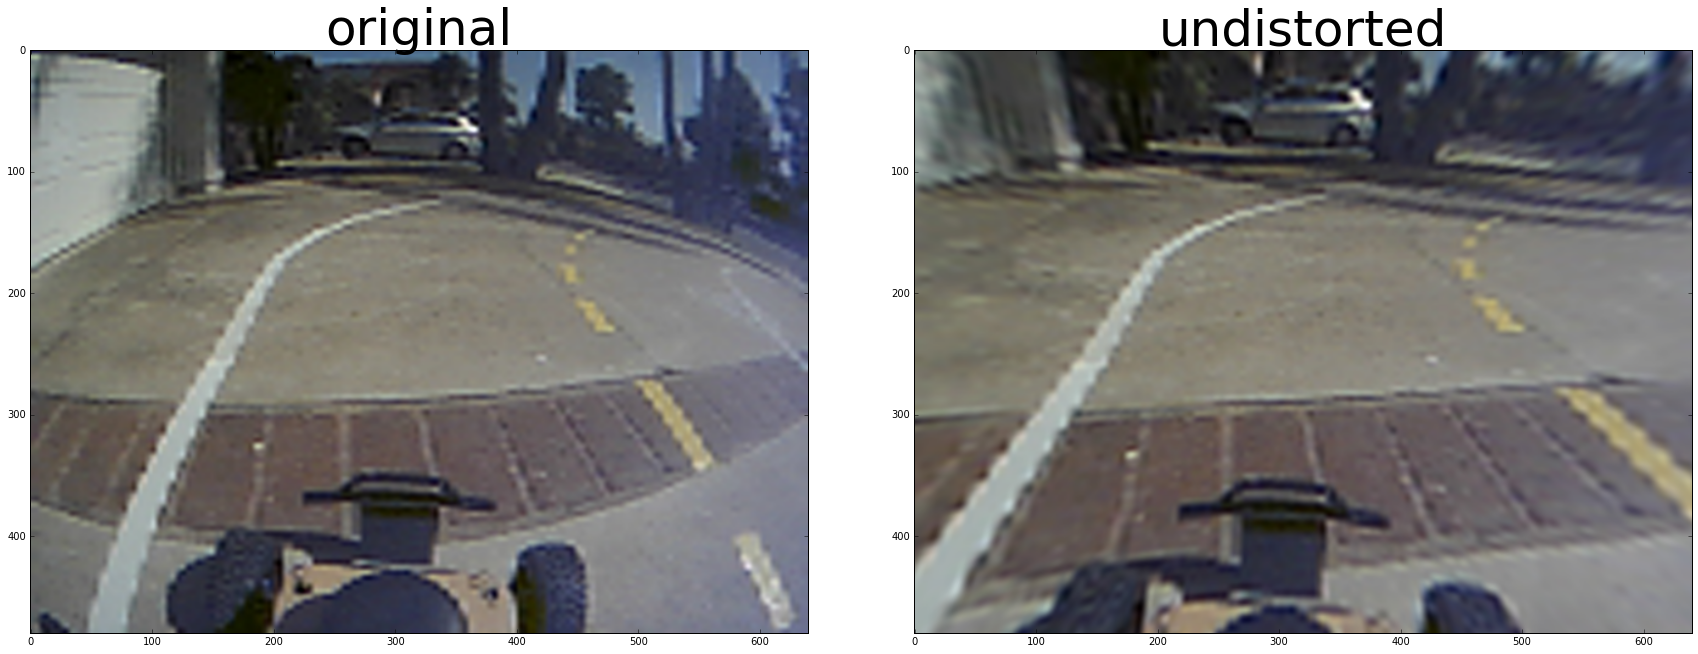

In [28]:
# Undistort image

def undistort(img, mtx, dist):
    '''
    Takes an image and camera maxtrix and distance coeffcients
    returns the undistorted image
    '''
    new_image = cv2.undistort(src=img, cameraMatrix=mtx, distCoeffs=dist)
    
    return new_image


# Read in an image
files = glob.glob("data/*.jpg")
img = cv2.imread(files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(img, None,fx=4, fy=4, interpolation = cv2.INTER_CUBIC)

und = undistort(img, mtx, dist)
display_n_images((img, und), ("original", "undistorted"))



In [15]:
import math

'''
make a polygon based on percentage of image dimensions
'''

def make_mask(img_size, #width, height tuple
              horizon_perc, # the upper threshold, as a percent of height
              bottom_perc, #the lower thresh, as a percent of height
              mask_bottom_perc = 1.0, #the lower percent of width
              mask_top_perc = 0.5): #the upper percent of width
    img_width = img_size[0]
    img_height = img_size[1]
    
    centerX = img_width / 2
    
    horizon_y = math.floor(horizon_perc * img_height)
    bottom_y_margin = math.floor(bottom_perc * img_height)
    bottom = img_height - bottom_y_margin
    top = horizon_y
    
    mask_bottom_left_x   = math.floor(centerX - img_width * (mask_bottom_perc * 0.5))
    mask_bottom_right_x  = math.floor(centerX + img_width * (mask_bottom_perc * 0.5))
    mask_top_left_x      = math.floor(centerX - img_width * (mask_top_perc * 0.5))
    mask_top_right_x     = math.floor(centerX + img_width * (mask_top_perc * 0.5))

    mask_points = [(mask_bottom_left_x,  bottom),
                   (mask_top_left_x,     top),
                   (mask_top_right_x,    top), 
                   (mask_bottom_right_x, bottom)]
    
    return mask_points

def apply_mask(img, mask_points):
    '''
    use the mask_points to black out region of image
    '''
    ignore_mask_color = 255
    mask = np.zeros_like(img)
    vertices =  np.array([mask_points], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    result = cv2.bitwise_and(img, mask)
    return result


In [16]:
def perspective_reverse(img, corners_src, corners_dest, img_size):
    '''
    take and image and four src points in a rhombus along the lane lines
    dest points in a more linear quad, warp image to straighten effects
    of perspective transformation.
    '''
    
    src = np.float32(corners_src)
    
    dst = np.float32(corners_dest)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, invM

def draw_lines(img, corners, color, line_w):
    n = len(corners)
    for i in range(n):
        iS = i
        iE = (i + 1) % n
        a = corners[iS]
        b = corners[iE]
        cv2.line(img, a, b, color, line_w)

In [133]:

'''
combine some masks
'''
def combine_masks(S, U, V, R, G, B, thresh=0.1):    
    combined = np.zeros_like(S, dtype=np.uint8)
    #combined[(S == 1) | (U == 1) | (R == 1) | (G == 1) | (B == 1)] = 1
    combined[(S + U + R + G + B) > thresh] = 1
    return combined

def color_thresold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H, L, S = cv2.split(hls)
    
    thresh = (150, 255)
    S = thresh_mask(S, thresh)

    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    R, G, B = cv2.split(rgb)

    thresh = (180, 255)
    R = thresh_mask(R, thresh)

    thresh = (180, 255)
    G = thresh_mask(G, thresh)

    thresh = (180, 255)
    B = thresh_mask(B, thresh)
    
    yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    Y, U, V = cv2.split(yuv)

    thresh = (50, 100)
    U = thresh_mask(U, thresh)
    
    thresh = (150, 255)
    V = thresh_mask(V, thresh)
    
    return combine_masks(S, U, V, R, G, B)


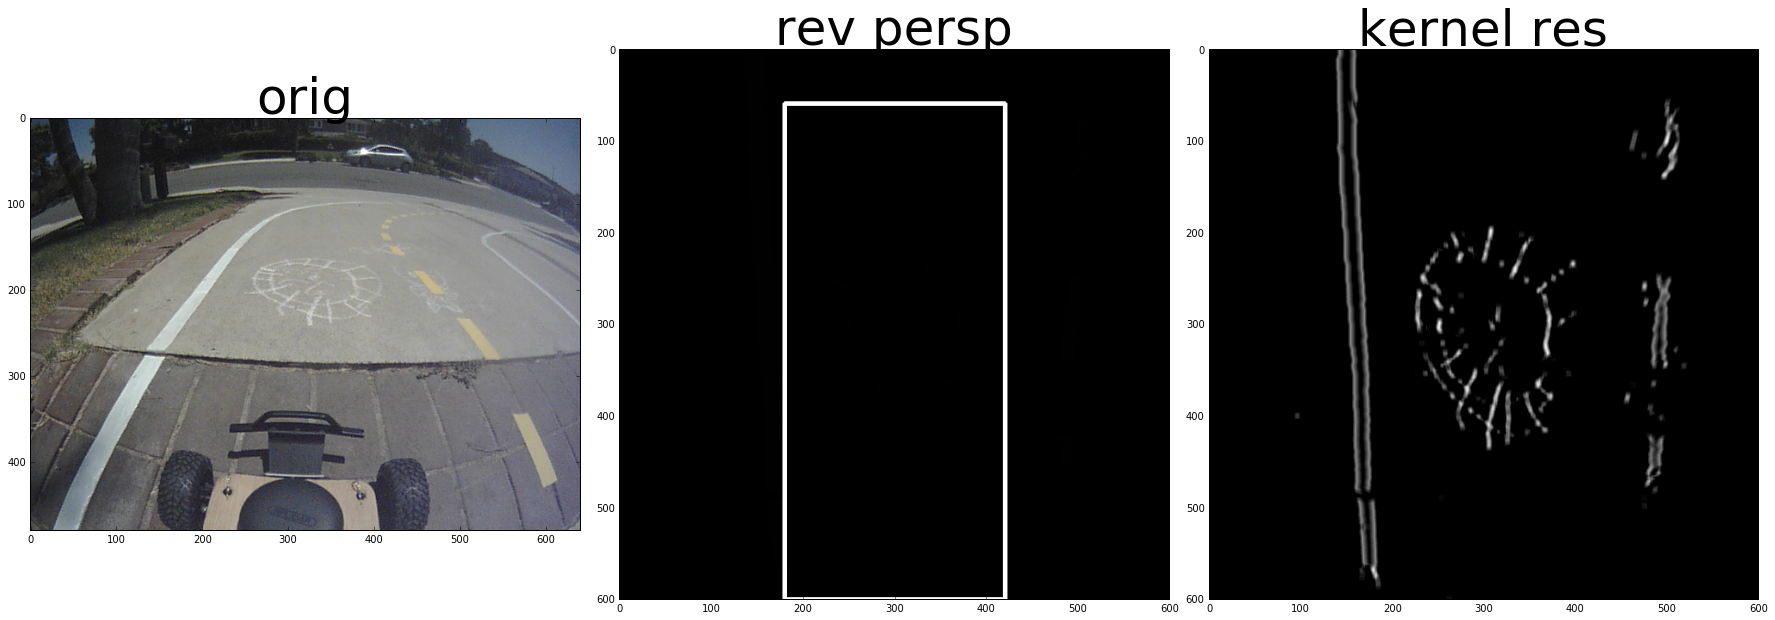

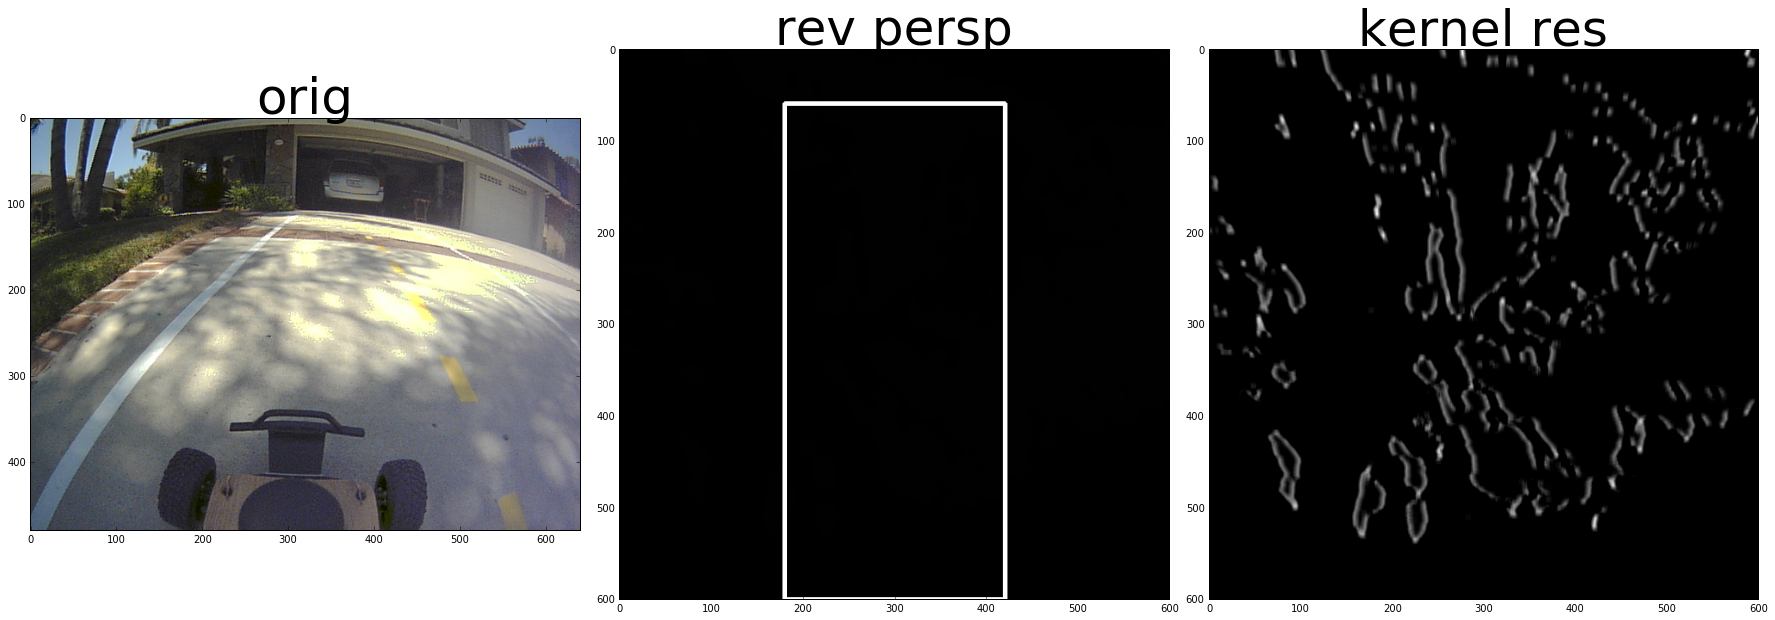

In [134]:
def kernel_mask(img):
    '''
    make a linear kernel to try to pull out lane lines
    '''
    nl = 6
    a = []
    for i in range(nl):
        a.append(-1)
    for i in range(nl):
        a.append(2)
    for i in range(nl):
        a.append(-1)
    kernel = np.array((
        #[-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 
        #[-1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, -1, -1, -1, -1, -1, -1]), 
        a, a, a, a, a, a), 
        dtype="int")
        
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    res = cv2.filter2D(img, -1, kernel)
    
    return res

def undist_thresh_rev_proj(img, debug=False):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    H, L, S = cv2.split(hls)
    Y, U, V = cv2.split(yuv)

    img = color_thresold(img)
    warped_size = (600, 600)

    '''
    camera was calibrated w 640x480 images, so upsample
    '''
    #img = cv2.resize(img, None, fx=4, fy=4, interpolation = cv2.INTER_CUBIC)
    img_size = (img.shape[1], img.shape[0])
    
    '''
    correct for camera distortion
    '''
    undistorted = undistort(img, mtx, dist)
    
    '''
    make polygon to reverse perspective distortion
    '''
    src_cn = make_mask(img_size, 0.3, 0.05, 1.0, 0.2)
    dest_cn = make_mask(warped_size, 0.1, 0.0, 0.4, 0.4)
    
    rev_persp, M, invM = perspective_reverse(undistorted, src_cn, dest_cn, warped_size)
    
    cv2.imwrite("test.png", rev_persp)
    
    kres = kernel_mask(rev_persp)
    
    if debug:
        draw_lines(undistorted, src_cn, (255, 0, 0), 3)
        draw_lines(rev_persp, dest_cn, (255), 3)

        display_n_images((rgb, rev_persp, kres), 
                         ("orig", "rev persp", 'kernel res'))
        
    return kres, M, invM 


files = glob.glob('data/*.jpg')[2:4]

for infile in files:
    img = cv2.imread(infile)
    undist_thresh_rev_proj(img, True)


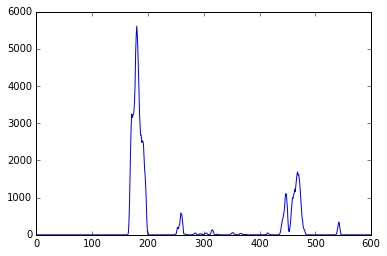

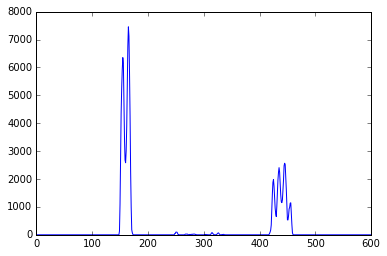

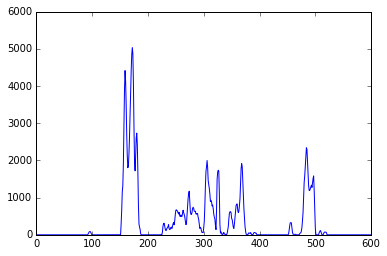

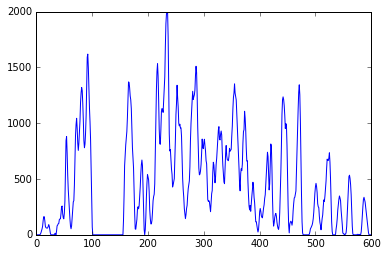

In [135]:
def thresh_mask(img, thresh, val=0.1):
    flt_img = np.zeros_like(img, dtype=float)
    flt_img[(img > thresh[0]) & (img <= thresh[1])] = val
    return flt_img

files = glob.glob('data/*.jpg')[0:4]

for infile in files:
    img = cv2.imread(infile)
    img, M, invM = undist_thresh_rev_proj(img, False)

    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.show()

In [ ]:
def kernel_mask(img):
    kernel = np.array((
        [-1, -1, 0, 0, 1, 1]), dtype="int")
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    res = cv2.filter2D(gray, -1, kernel)
    
    return res
